In [1]:
#pip install prophet

In [2]:
import pandas as pd
from prophet import Prophet
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("../data/processed/05_housing_data_renamed_columns.csv", parse_dates=["date"])

In [4]:
df_non_us = df[df["region_name"] != "United States"].copy()
df_non_us = df_non_us[[
    "region_name", "date", "zhvi_all_homes", "median_income",
    "unemployment_rate", "sales_tax", "income_tax"
]].dropna()

df_us = df[df["region_name"] == "United States"].copy()

df_us["median_income"] = df_us["median_income"].fillna(0)
df_us["unemployment_rate"] = df_us["unemployment_rate"].fillna(0)
df_us["sales_tax"] = df_us["sales_tax"].fillna(0)
df_us["income_tax"] = df_us["income_tax"].fillna(0)

df_cleaned = pd.concat([df_non_us, df_us], ignore_index=True)

In [5]:
forecast_months = 48
all_forecasts = []
variables_to_forecast = ["median_income", "unemployment_rate", "sales_tax", "income_tax"]
regions = df["region_name"].unique()

In [6]:
for region in regions:
    region_df = df_cleaned[df_cleaned["region_name"] == region].copy()
    if len(region_df) < 48:
        continue

    forecasted_vars = []
    for var in variables_to_forecast:
        model_df = region_df[["date", var]].rename(columns={"date": "ds", var: "y"})
        model = Prophet()
        model.fit(model_df)
        future = model.make_future_dataframe(periods=forecast_months, freq='M')
        forecast = model.predict(future)[["ds", "yhat"]].rename(columns={"yhat": var})
        forecasted_vars.append(forecast)

    forecast_df = forecasted_vars[0]
    for f in forecasted_vars[1:]:
        forecast_df = pd.merge(forecast_df, f, on="ds")

    forecast_df["region_name"] = region
    full_df = pd.merge(region_df[["date", "zhvi_all_homes"]], forecast_df, left_on="date", right_on="ds", how="right")

    train_data = full_df.dropna(subset=["zhvi_all_homes"]).copy()
    X_train = train_data[variables_to_forecast]
    y_train = train_data["zhvi_all_homes"]

    model_lr = LinearRegression()
    model_lr.fit(X_train, y_train)

    X_future = forecast_df[variables_to_forecast]
    forecast_df["zhvi_forecast"] = model_lr.predict(X_future)

    forecast_df = forecast_df[["region_name", "ds", "zhvi_forecast", "median_income", "unemployment_rate", "sales_tax", "income_tax"]]
    forecast_df.rename(columns={"ds": "date"}, inplace=True)

    all_forecasts.append(forecast_df)

23:09:01 - cmdstanpy - INFO - Chain [1] start processing
23:09:02 - cmdstanpy - INFO - Chain [1] done processing
I:\Programs\Python\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
23:09:02 - cmdstanpy - INFO - Chain [1] start processing
23:09:02 - cmdstanpy - INFO - Chain [1] done processing
I:\Programs\Python\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
I:\Programs\Python\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
I:\Programs\Python\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
23:09:03 - cmdstan

In [7]:
final_result = pd.concat(all_forecasts, ignore_index=True)

final_result = final_result[final_result["date"] <= pd.Timestamp("2026-12-31")]
final_result.to_csv('../data/processed/07_final_zhvi_forecast_3yr.csv', index=False)

print("File successfully saved to 'data/processed/07_final_zhvi_forecast_3yr.csv'")

File successfully saved to 'data/processed/07_final_zhvi_forecast_3yr.csv'


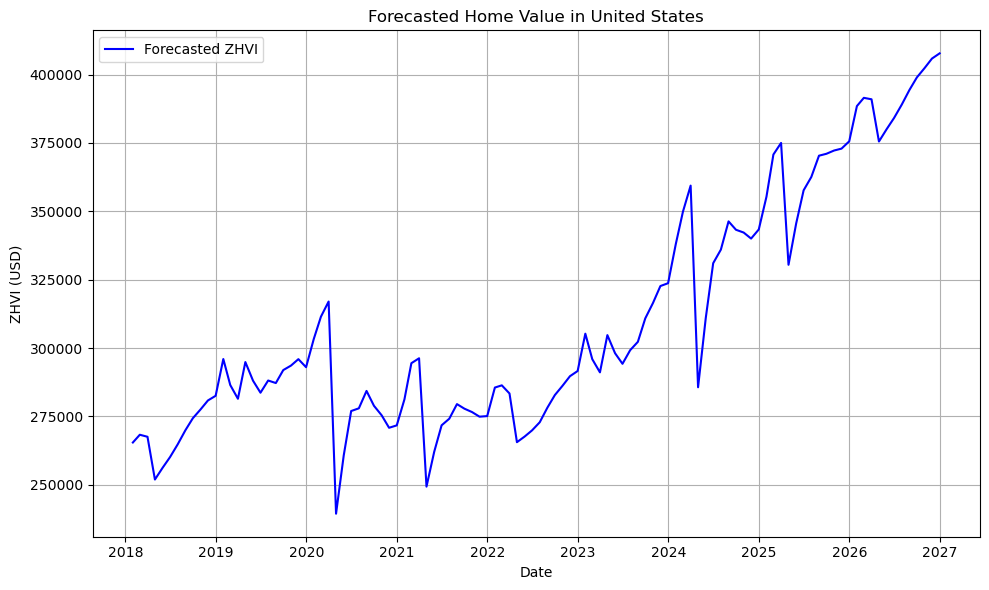

In [8]:
region = "United States"
region_df = final_result[final_result["region_name"] == region].copy()

plt.figure(figsize=(10, 6))
plt.plot(region_df["date"], region_df["zhvi_forecast"], linestyle='-', color='blue', label="Forecasted ZHVI")

plt.title(f"Forecasted Home Value in {region}")
plt.xlabel("Date")
plt.ylabel("ZHVI (USD)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()